In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))
    data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))

    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"][1:]))
    data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"][1:]))


    return data

def arrayToColors(data):

    data=(data-np.min(data))/(np.max(data)-np.min(data))
    return mpl.cm.plasma(np.array(data))

def reloadData():
    global data
    data=[]
    
    files=glob.glob("data/*")

    for name in files:
        pointiness,spacing=name.split("spacing")
        pointiness=float(pointiness[15:-1])
        spacing=float(spacing[:-4])

        try:
            thisData=loadFile(name+"\\table.txt")
            thisData.attrs["pointiness"]=pointiness
            thisData.attrs["spacing"]=spacing
            data.append(thisData)
        except Exception:
            continue

reloadData()


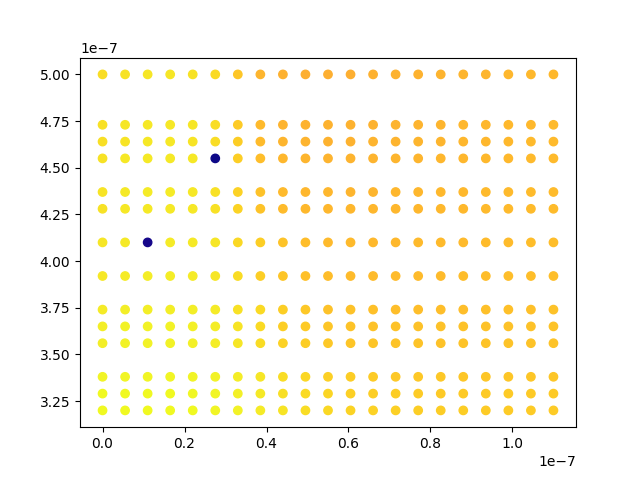

In [3]:
pointiness=[]
spacing=[]
Hc=[]
Br=[]

for run in data:
    pointiness.append(run.attrs["pointiness"])
    spacing.append(run.attrs["spacing"])
    Hc.append(run.attrs["Hc"])
    Br.append(run.attrs["Br"])
plt.scatter(pointiness,spacing,c=arrayToColors(Br))
plt.show()
plt.scatter(pointiness,spacing,c=arrayToColors(Hc))

In [4]:
for run in data:
    if run.attrs["Br"]==min(Br):
        plt.plot(run["H"],run["m"])
        print(run.attrs)

{'Hc': 493.3333333333333, 'Br': 0.42294907052352165, 'pointiness': 2.75e-08, 'spacing': 4.55e-07}


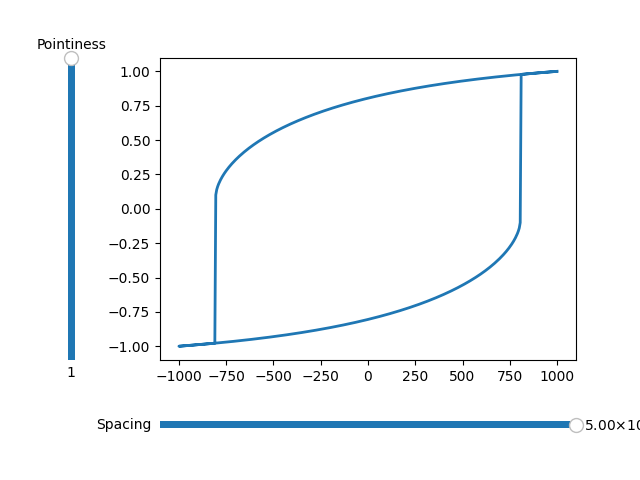

In [5]:
from matplotlib.widgets import Slider
%matplotlib widget

# Define initial parameters
init_spacing = 5
init_pointiness = 3

def getClosestPlot(spacing,pointiness):
    minDist=None
    bestRun=None
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)+abs(run.attrs["pointiness"]-pointiness)
        if minDist is None or dist<minDist:
            minDist=dist
            bestRun=run
    return bestRun

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
bestData=getClosestPlot(init_spacing,init_pointiness)
line, = ax.plot(bestData["H"],bestData["m"], lw=2)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

axspacing = fig.add_axes([0.25, 0.1, 0.65, 0.03])
spacing_slider = Slider(
    ax=axspacing,
    label='Spacing',
    valmin=3.25e-7,
    valmax=5e-7,
    valinit=init_spacing,
)

# Make a vertically oriented slider to control the amplitude
axpointy = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
pointy_slider = Slider(
    ax=axpointy,
    label="Pointiness",
    valmin=0,
    valmax=1,
    valinit=init_pointiness,
    orientation="vertical"
)

# The function to be called anytime a slider's value changes
def update(val):
    bestData=getClosestPlot(spacing_slider.val,pointy_slider.val*1.5e-7)

    line.set_ydata(bestData["m"])
    fig.canvas.draw_idle()

spacing_slider.on_changed(update)
pointy_slider.on_changed(update)



plt.show()